# ML: Supervised algorithm - NLP - Reviews Analysis

# Introduction

The objective is to train a model that, from the text of a review, can detect how positive or negative it is.

We are going to work with the dataset restaurant_ratings.csv which has 4 variables:

* Name: the name of the restaurant
* Rating: the number of stars given by the user.
* Review: the review written by the user.
* Bad: 0 if the review is considered good (if its rating is equal or higher than 2.5), 1 if it is considered bad (if its rating is lower than 2.5).

Train a rating model using the "bad" column as a target. Remove the "name" and "rating" columns. The first one does not provide anything useful. And the second one is not supposed to be known when we receive a review, since in the scenario we are supposed to receive only the text of the review.

As a reminder, the main steps to perform are:

1. Scanning the data (checking for nulls, removing nulls, etc.).
2. Preprocessing and cleaning of the texts
    * Vectorisation of the texts.
3. Training model: Multinomial Bayes, Logistic Regression and Decision Tree Classifier
4. Evaluation. Remember here also that the classification is multi-class, so you have to use metrics that are suitable for this type of classification.
5. Explanation: use some tool to explain why your model makes the predictions it does.

## 1. Import libraries

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,balanced_accuracy_score,roc_curve, auc
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.pipeline import make_pipeline

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# explanation
from lime import lime_text
from lime.lime_text import LimeTextExplainer 



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Define functions

In [2]:
# Function for text cleaning, initial phase
def clean_text(text): 
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    text = re.sub('\n', '', text) #remove newlines
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text


# Pre-processing function
def text_preprocessing(text):
    
    # 1. Data cleaning on the text variable
    nopunc = clean_text(text)
    
    # 2. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = tokenizer.tokenize(nopunc)
    
    # 3. Remove stopwords
    remove_stopwords = [w for w in nopunc if w not in stop_words]
    
    # 4. Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(w) for w in remove_stopwords]
    
    # 5. Join the information
    combined_text = ' '.join(lemma)
    return combined_text

def wordcloud_maker(badreviews,goodreviews):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

    wordcloud1 = WordCloud(background_color='black',
                        width=600,
                        height=400).generate(" ".join(badreviews))

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Bad reviews',fontsize=40)

    wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(goodreviews))
    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Good reviews',fontsize=40);

## 3. Load datasets

In [3]:
df=pd.read_csv('restaurant_ratings.csv')

In [4]:
df.head()

,Unnamed: 0,name,rating,review,bad
0,228122,Crawl Street,3.0,Ambience 35 Too noisy\nFood 3\nService 4\n...,0.0
1,400236,The Spicy Kitchen,1.0,If I could I would rate it in negativeWorst s...,1.0
2,35438,Kabab Treat,5.0,Hemanth reddyK,0.0
3,262748,Pooja Veg,4.0,Try out the filter coffee masala dosa idly and...,0.0
4,1008738,Ammi's Biryani,3.5,Decent Mutton Biryani Consistent I have tried ...,0.0


## 4. Dataset analysis

In [5]:
df.sample(10)

,Unnamed: 0,name,rating,review,bad
105680,1080013,Skoolroom,4.0,Welcomed with ice lollies and greeted with all...,0.0
29818,947648,Ice & Spice,5.0,Burger was excellent,0.0
1391,613732,Go Italia,4.0,This place is quite close to my place and so c...,0.0
100138,148180,Sidewalk - The Garden Bar,4.0,A nice and different kind of place located in ...,0.0
6491,946580,Sidewalk Cafe - Nahar's Heritage Hotel,3.0,Has some good competent stuff The Sandwiches w...,0.0
54853,999764,Melange - Radisson Blu,5.0,The best buffet place in town Particularly imp...,0.0
84361,1097258,Funjabi,5.0,Guys if u want the best food in bangalore in a...,0.0
83862,441131,Healthie,5.0,Tried healthie for the first time and must say...,0.0
58473,1211179,Nagarjuna,5.0,This is a restaurant that is always crowded bu...,0.0
90298,99642,Little Green Cafe,4.0,Little green cafe is located in the heart of c...,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121814 entries, 0 to 121813
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  121814 non-null  int64  
 1   name        121814 non-null  object 
 2   rating      121814 non-null  float64
 3   review      121492 non-null  object 
 4   bad         121814 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.6+ MB


In [7]:
df['bad'].value_counts()

0.0    100756
1.0     21058
Name: bad, dtype: int64

In [8]:
df.groupby(['rating','bad'])['name'].count()

rating  bad
1.0     1.0    14093
1.5     1.0      830
2.0     1.0     6135
2.5     0.0     1533
3.0     0.0    16812
3.5     0.0     5347
4.0     0.0    37176
4.5     0.0     4908
5.0     0.0    34980
Name: name, dtype: int64

* See that we have the column "Unnamed" which does not contribute any information to our project. We eliminate it.
* See that the bad (target) variable is imbalanced and this may affect the predictions we make a posteriori.
* Observe nulls in "review", and it is likely that we also have strings full of "spaces" which, in short, are equivalent to nulls in our study.
* Observe that all "reviews" with "rating" <2, are classified as "bad"=1. Although we should not know this information.

## 5. Pre-processing and cleaning of texts

It can be seen that we have the "Unnamed", "name" and "rating" columns that do not contribute any information to our project. We eliminate it

In [9]:
df.drop(columns=['Unnamed: 0', 'name', 'rating'], inplace=True)

Note that we have nulls in the review column. Since this is a non-substantial number of records with respect to the total, we eliminate them.

In [10]:
df.isnull().sum()

review    322
bad         0
dtype: int64

In [11]:
df.dropna(axis=0, inplace=True)

In [12]:
df.isnull().sum()

review    0
bad       0
dtype: int64

Check for duplicates and we find that we have duplicates, but name can be duplicated, rating or bad too. Now, we are interested in not having duplicate reviews. We will eliminate the copies and we will be left, logically, with a single copy of each duplicate review.

In [13]:
df.duplicated(subset=['review']).sum()

65289

In [14]:
df.drop_duplicates(subset=['review'],keep='first', inplace=True)

In [15]:
df.duplicated(subset=['review']).sum()

0

Note that within the reviews there are all kinds of formats, including scores or enumerations, which we will have to ignore in our processing/tokenisation.

Now we are going to apply the "clear text" cleaning function

In [16]:
df['review2'] = df['review'].apply(lambda x: clean_text(x))

In [17]:
df.head(10)[['review', 'review2']]

,review,review2
0,Ambience 35 Too noisy\nFood 3\nService 4\n...,ambience too noisyfood the zomato revie...
1,If I could I would rate it in negativeWorst s...,if i could i would rate it in negativeworst s...
2,Hemanth reddyK,hemanth reddyk
3,Try out the filter coffee masala dosa idly and...,try out the filter coffee masala dosa idly and...
4,Decent Mutton Biryani Consistent I have tried ...,decent mutton biryani consistent i have tried ...
5,Great ambience good food and best service by t...,great ambience good food and best service by t...
6,Ambiance The live music and the quirky decor ...,ambiance the live music and the quirky decor ...
7,Food tastes really good Very Different Chinese...,food tastes really good very different chinese...
8,Extremely happy about my orderthe food was als...,extremely happy about my orderthe food was als...
9,didnt get half my order zomato credited me th...,didnt get half my order zomato credited me th...


Analyse a sample of each type of target/target classification for the variable 'bad' and plotted a word cloud to observe the most frequently occurring words and weigh their predictive power, to filter out possible context-specific stopwords.

In [18]:
good_review = df[df['bad']==0]['review']
good_review.reset_index(drop=True, inplace=True)
print(good_review[15])
print('--------')
print(good_review[25])

Prost brew pub in kormangala is a very famous and a cool place to hangout and chill with your friends and also they have live events going on everytime

Ambience  The place is very huge and has 3 floors of seating with breweries fitted on the first floor They have a cool rustic ambience with a trendy lights all over the place but the elevators dont work

Food  We ordered the paneer tikka and it was minced with spices and also was freshly cooked With the paneer being good we then ordered the white sauce pasta and it was normal not too much to tell And for the last order we went for the half dozen burgers platter which seemed very interesting and the food came but they were all of same patty which seemed very bland and also were served with alot of fries

Parking  Valet parking is available

Food  45
Service  45
Ambience  45
Price  45

Happy fooding
--------
1 Taste 355 Food is good but not that happy with communti shots Was diluted

2Food Quality 45

3Value for money45 For a location li

In [19]:
bad_review = df[df['bad']==1]['review']
bad_review.reset_index(drop=True, inplace=True)
print(bad_review[15])
print('--------')
print(bad_review[25])

We ordered the beef shawarma jumbo roll and chicken roll The beef rolls were not fit for human consumption The meat was terrible It wasnt cooked at all and even after heating it in the microwave it tasted like chewing gum
--------
I was here with a friend of mine for lunch and it was an absolutely awful experience The ambience was bad and so was the service which I thought was really slow And the place was totally unsanitary House flies were swarming our table and they were all over our food all the time The entire place was really stuffy thanks to their really poor exhaust system  fumes from their oven could make your life miserable

The food was nothing to write home about either The pasta was overcooked and the cold coffee tasted like nothing but milk

I wish I had at least one nice thing to say about the place not unfortunately no


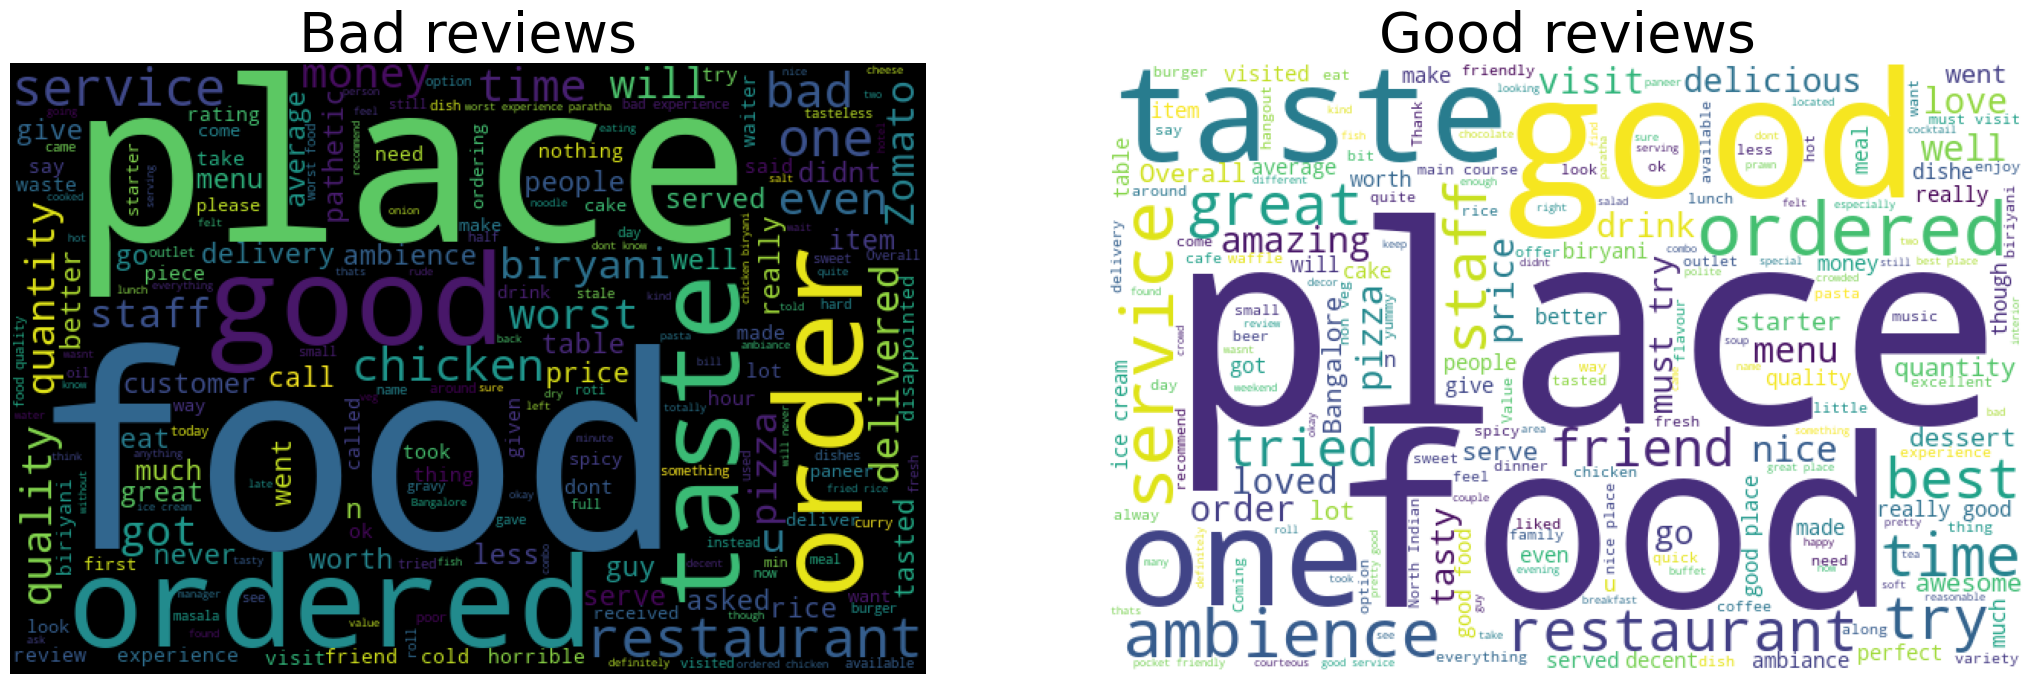

In [20]:
wordcloud_maker(bad_review,good_review)

We work with restaurant reviews, so in this context there are words that can be considered stop words, due to their low predictive power, e.g. food. We are going to update what will be our list of stop words that we will pass to the algorithm.

In [21]:
stop_words = set(stopwords.words('english'))
stop_words.update(["food", "place", "restaurant", "ordered", "try", "tried", 'one', 'staff', 'eat', 'ate', 'menu', 'drink','service'])

To improve the word clouds we will further "normalise" our data and update the cloud:

* We get the word tokens.
* We remove stopwords.

In [22]:
df['review3'] = df['review'].apply(lambda x : text_preprocessing(x))

In [23]:
bad_review3 = df[df['bad']==1]['review3']
good_review3 = df[df['bad']==0]['review3']

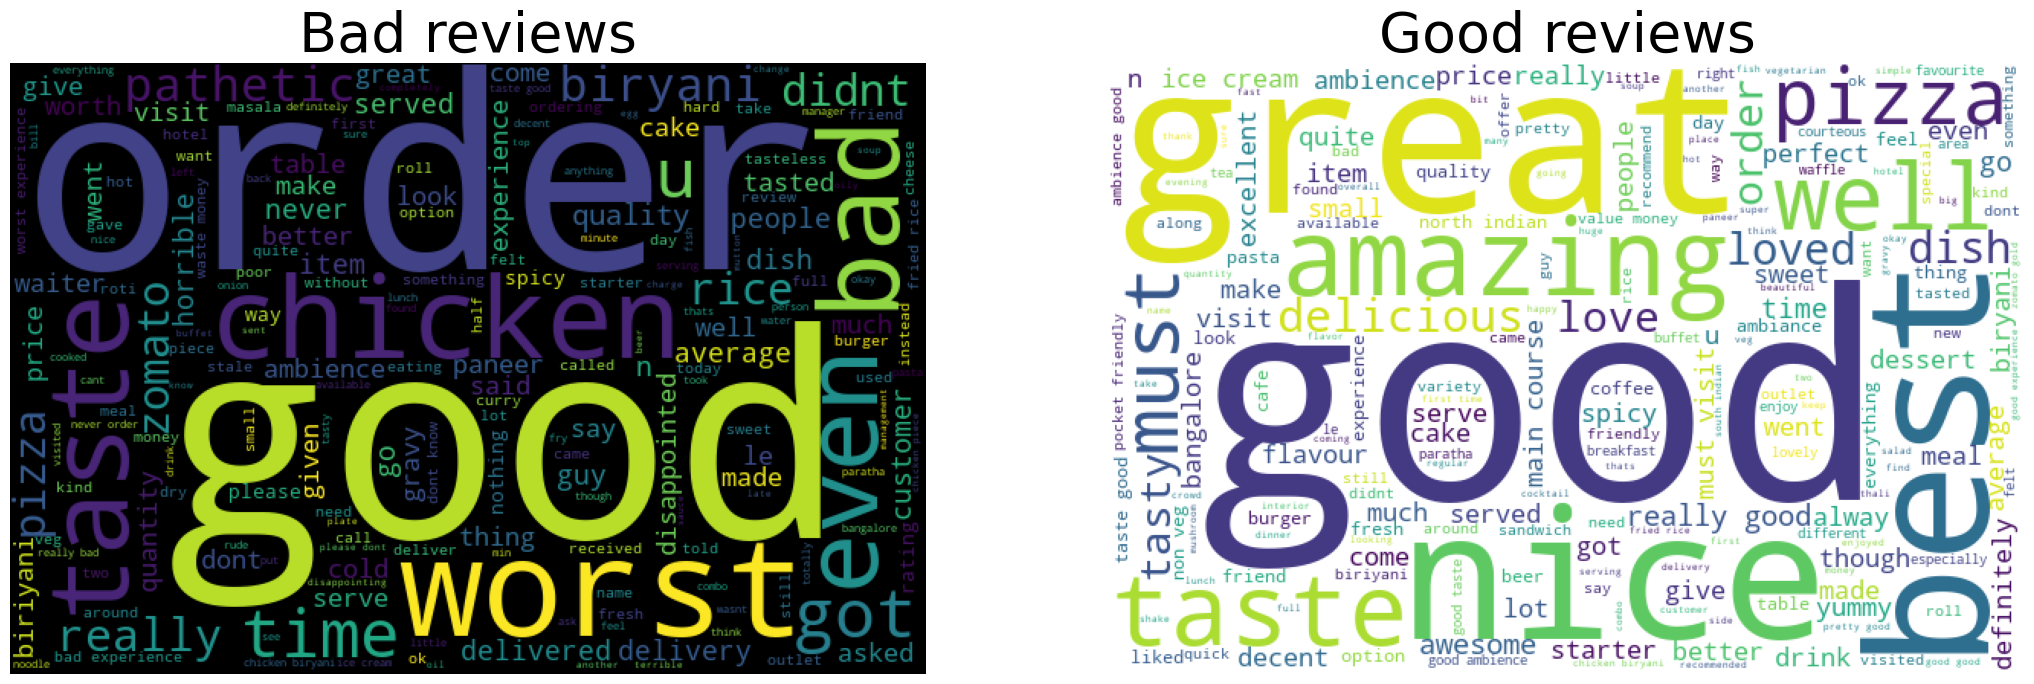

In [24]:
wordcloud_maker(bad_review3,good_review3)

See that we can continue debugging the stopwords:
* good: appears in both clouds. Without going into detail, possibly due to the use of sarcasm in negative evaluations or opinions composed of pros and cons. It certainly does not contribute being present in both classifications.
* order: as an action, it doesn't decant or denote positivity or negativity.
* chicken: seems to be the least celebrated dish, but we are not going to demonise a food... Just as "order" has little predictive power in the context we are working with, it has no ability to predict a good or bad review, as it can appear perfectly well in both contexts. The same happens with other dishes, ingredients that will also be extracted under the same reasoning.
* taste: idem "order".

In [25]:
stop_words.update(['good','order','chicken','taste','biryani','rice', 'pizza', 'dessert', 'drink', 'zomato', 'paneer'])

In [26]:
df['review4'] = df['review'].apply(lambda x : text_preprocessing(x))

In [27]:
bad_review4 = df[df['bad']==1]['review4']
good_review4 = df[df['bad']==0]['review4']

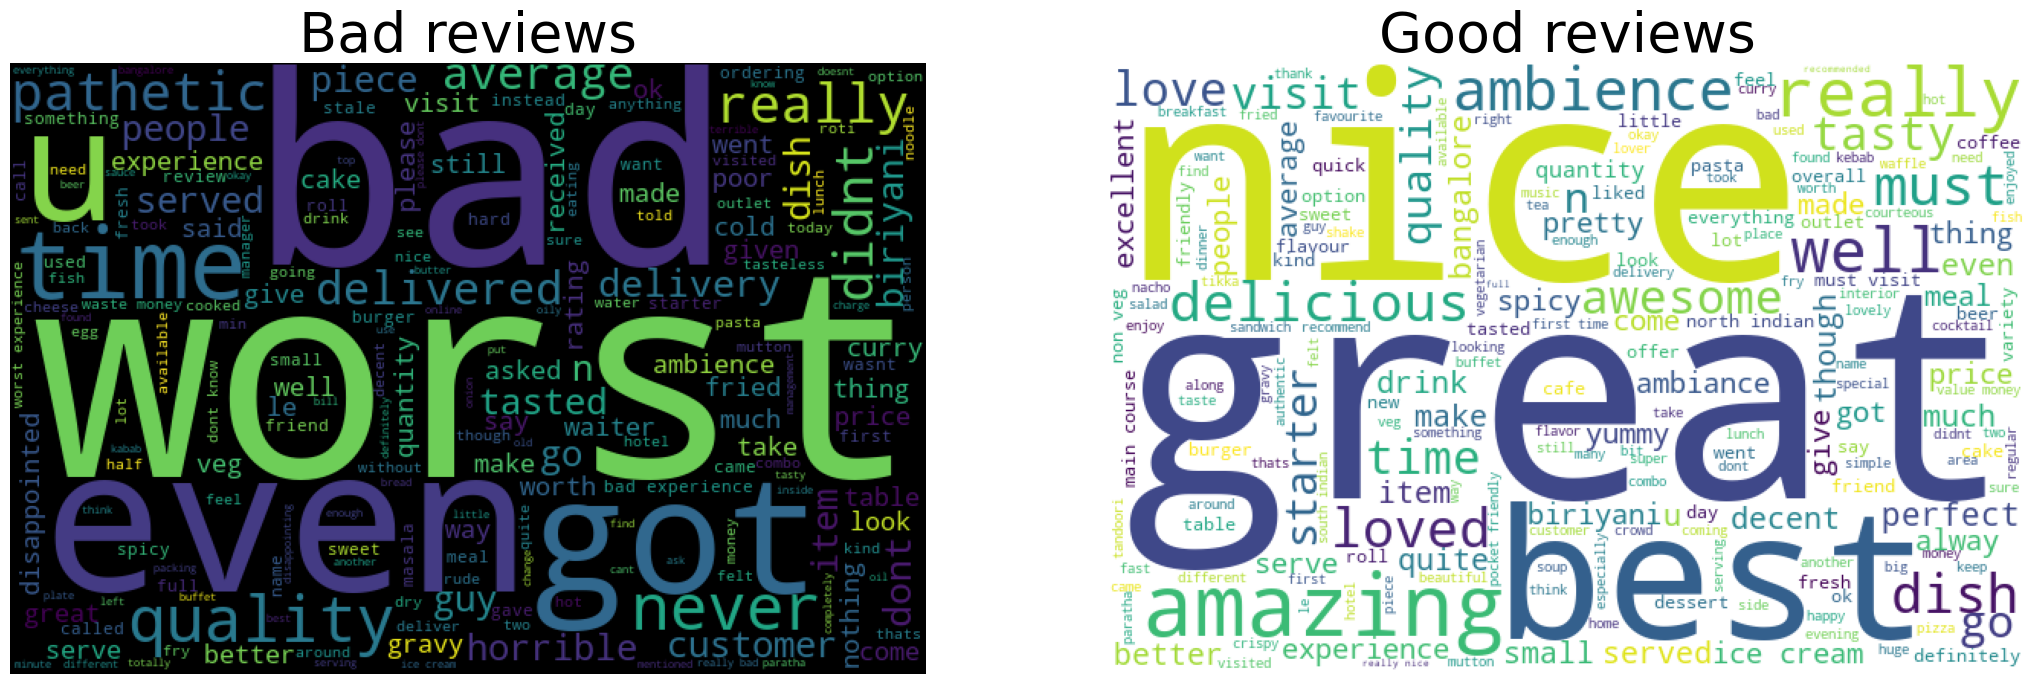

In [28]:
wordcloud_maker(bad_review4,good_review4)

In [29]:
df.sample(5)

,review,bad,review2,review3,review4
27856,Tempura shrimp sushi rolls 55\nCantonese style...,0.0,tempura shrimp sushi rolls style chicken pan ...,tempura shrimp sushi roll style chicken pan fr...,tempura shrimp sushi roll style pan fried nood...
44867,I did not get the order at all but I was charg...,1.0,i did not get the order at all but i was charg...,get order charged ridiculous,get charged ridiculous
3389,all you mallus and mallu food lovers This is t...,0.0,all you mallus and mallu food lovers this is t...,mallus mallu lover always wanted taste typical...,mallus mallu lover always wanted typical keral...
43321,Good food for a quick hunger fix Or for a Chin...,0.0,good food for a quick hunger fix or for a chin...,good quick hunger fix chinese cravingthis chic...,quick hunger fix chinese cravingthis hakka noo...
90043,Its so yummy Here the biryanis having differen...,0.0,its so yummy here the biryanis having differen...,yummy biryani different taste raita side gravy...,yummy biryani different raita side gravy also ...


Dataset still supports further cleaning through stopwors. We validate the current state and move forward with the vectorisation of the dataset.

## 6. Train model

In the first instance, we will use a TF-IDF vectorisation, which takes into account both the frequency and the relevance of words based on bounded usage, and therefore has high predictive power within the corpus.

In [30]:
tfidf = TfidfVectorizer(max_features=1500,
                        min_df=2,
                        max_df=0.5,
                        ngram_range=(1, 2))

df_tfidf = tfidf.fit_transform(df['review4'])

In [31]:
df_tfidf.toarray().shape

(56203, 1500)

In [32]:
df_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Prepare the dataset to separate it into train and test.

In [33]:
y = df['bad']
X = df_tfidf

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=678)

Let's train 3 different models: MNBayes, DecisionTreeClassifier, LogisticRegression. In addition, we will search for the best possible parameter settings through the use of GridSearchCV.

Note: it's worth mentioning that we have tried to implement ensemble algorithms such as Stacking, Bagging and Boosting, as well as a simple SVC model. In no case has it been possible due to lack of computational capacity.

Comenzamos por __MultiNomialBayes__

In [35]:
clf_MNB = MultinomialNB()
MNB_parameters = {'alpha' : [0,0.25,0.5,1],}

grid_search = GridSearchCV(estimator = clf_MNB, 
                           param_grid = MNB_parameters, 
                           scoring = 'recall', 
                           cv = 4)
grid_search = grid_search.fit(X_train, y_train)


best_parameters = grid_search.best_params_
best_recall = grid_search.best_score_
print(best_parameters)
print(best_recall)

{'alpha': 0}
0.5733420218733218


In [36]:
clf_MNB = MultinomialNB(alpha=0)
MNB = clf_MNB.fit(X_train, y_train)
y_pred_test_MNB = MNB.predict(X_test)
y_pred_train_MNB = MNB.predict(X_train)

To evaluate model we will focus on the Recall metric, which measures the % of correctly predicted positive observations, our ultimate goal. However, we will also obtain the Precision and F1-Score metrics to get a more complete picture. 

Finally, we will do the metrics for predictions on test dataset, but also on train. If we observe a very high disparity in favour of train, it would mean overfitting.

In [37]:
print("Precision test: "+str(precision_score(y_test,y_pred_test_MNB)))
print("Precision train: "+str(precision_score(y_train,y_pred_train_MNB)))
print()
print("Recall test: "+str(recall_score(y_test,y_pred_test_MNB)))
print("Recall train: "+str(recall_score(y_train,y_pred_train_MNB)))
print()
print("F1 test: "+str(f1_score(y_test,y_pred_test_MNB)))
print("F1 train: "+str(f1_score(y_train,y_pred_train_MNB)))

Precision test: 0.8449931412894376
Precision train: 0.8655048304603145

Recall test: 0.5728456292622442
Recall train: 0.5889404485692189

F1 test: 0.6828006650655829
F1 train: 0.7009281276367262


Apply the same procedure in __LogisticRegression__

In [38]:
clf_LR = LogisticRegression()
LR_parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'solver' : ['lbfgs','liblinear','newton-cg','newton-cholesky'],
    'max_iter' : [50,150,300],
    'warm_start' : [False, True]
}

grid_search = GridSearchCV(estimator = clf_LR, 
                           param_grid = LR_parameters, 
                           scoring = 'recall', 
                           cv = 4)
grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_recall = grid_search.best_score_
print(best_parameters)
print(best_recall)

{'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True}
0.6871604557562353


In [39]:
clf_LR = LogisticRegression(max_iter=50, penalty='l1', random_state=1234, solver='liblinear', warm_start=False)
LR = clf_LR.fit(X_train, y_train)
y_pred_test_LR = LR.predict(X_test)
y_pred_train_LR = LR.predict(X_train)

In [40]:
print("Precision test: "+str(precision_score(y_test,y_pred_test_LR)))
print("Precision train: "+str(precision_score(y_train,y_pred_train_LR)))
print()
print("Recall test: "+str(recall_score(y_test,y_pred_test_LR)))
print("Recall train: "+str(recall_score(y_train,y_pred_train_LR)))
print()
print("F1 test: "+str(f1_score(y_test,y_pred_test_LR)))
print("F1 train: "+str(f1_score(y_train,y_pred_train_LR)))

Precision test: 0.8123188405797102
Precision train: 0.8494085532302093

Recall test: 0.6949783013019218
Recall train: 0.7219644238205724

F1 test: 0.7490811894420314
F1 train: 0.7805183946488294


Finally __DecisionTreeClassifier__

In [41]:
clf_DT = DecisionTreeClassifier()
DT_parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [10,30,50],
    'max_features' : ['sqrt','log2'],
    'ccp_alpha' : [0.1, 0.01, 0.001, 0.0001,0]
}

grid_search = GridSearchCV(estimator = clf_DT, 
                           param_grid = DT_parameters, 
                           scoring = 'recall', 
                           cv = 4)
grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_recall = grid_search.best_score_
print(best_parameters)
print(best_recall)

{'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt'}
0.4444520504245466


In [42]:
clf_DT = DecisionTreeClassifier(criterion='gini',max_depth=50, max_features='sqrt' ,ccp_alpha=0.0001, random_state=1234)
DT = clf_DT.fit(X_train, y_train)
y_pred_test_DT = DT.predict(X_test)
y_pred_train_DT = DT.predict(X_train)

In [43]:
print("Precision test: "+str(precision_score(y_test,y_pred_test_DT)))
print("Precision train: "+str(precision_score(y_train,y_pred_train_DT)))
print()
print("Recall test: "+str(recall_score(y_test,y_pred_test_DT)))
print("Recall train: "+str(recall_score(y_train,y_pred_train_DT)))
print()
print("F1 test: "+str(f1_score(y_test,y_pred_test_DT)))
print("F1 train: "+str(f1_score(y_train,y_pred_train_DT)))

Precision test: 0.707227813357731
Precision train: 0.7732164208848147

Recall test: 0.4792312461252325
Recall train: 0.5001288992008249

F1 test: 0.5713229859571323
F1 train: 0.6073888541014402


According to the Recall metric, the best model is LogisticRegression with 69% of correctly predicted positive rankings.

Overall, there is no evidence of overfitting.

## 7. Explain model

Use the Lime tool in order to explain the predictions it makes and to test the goodness of fit of the model.

In [44]:
bad_review4.reset_index(inplace=True, drop=True)

waited well min served stale sharwma fing end naaaaasty mouth serving size tiny like really smallif last option look dont find thing starve safer option
[[0.28601805 0.71398195]]


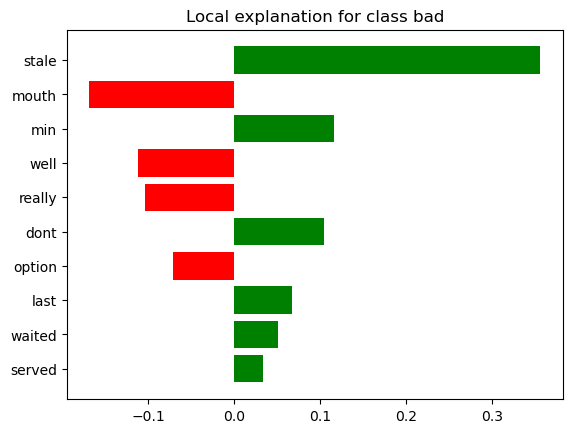

In [53]:
vect=tfidf
classifier = LR
c = make_pipeline(vect, classifier)

y_pred_prob = classifier.predict_proba(X_test)[:, 1]
mystring = bad_review4[35] 
print(mystring)
print(c.predict_proba([mystring]))
class_names = ["good", "bad"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_instance=mystring, 
                                 classifier_fn=c.predict_proba, 
                                 num_features=10,distance_metric='cosine')
fig = exp.as_pyplot_figure()

In [46]:
good_review4.reset_index(inplace=True, drop=True)

planning fava ub city forever never got loved fact opened close u boy u went sunday afternoon non veg mezze duet grill hummus sauce yum beautifully cooked presentation delight served chocolate truffle end heavenly nice courteous must visit list
[[0.99385299 0.00614701]]


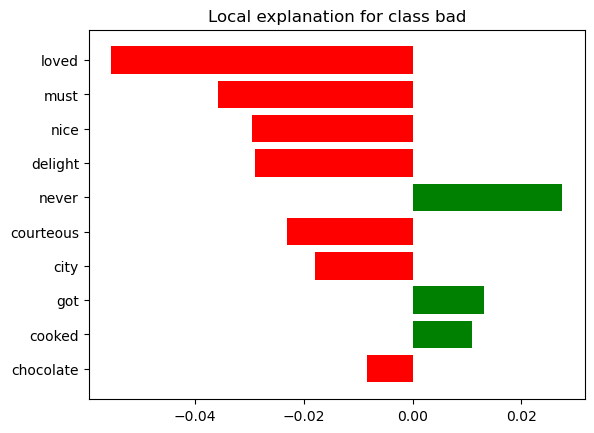

In [55]:
vect=tfidf
classifier = LR
c = make_pipeline(vect, classifier)

y_pred_prob = classifier.predict_proba(X_test)[:, 1]
mystring = good_review4[26] 
print(mystring)
print(c.predict_proba([mystring]))
class_names = ["good", "bad"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_instance=mystring, 
                                 classifier_fn=c.predict_proba, 
                                 num_features=10,distance_metric='cosine')
fig = exp.as_pyplot_figure()

A correct predictive behaviour is observed, even though it is still noticeable in the predictor variables that we continue to have words that can be considered stopwords: city, got, burger, wing. So we should start at the beginning and improve the cleaning already done.